In [1]:
import pickle
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm 

import config
import utils

from energy_py import EnergyFunctionCalculator, energy_calc_msa, energy_calc_single
import energy_py

WT = config.WT_AA_TENSOR.numpy()


In [2]:
model_prefix = "DHFR_incl_main_kit_taq_mse"


h_i_a = torch.load(f"../working/{model_prefix}_h_i_a.pt").numpy()
e_i_a_j_b = torch.load(f"../working/{model_prefix}_e_i_a_j_b.pt").numpy()
#e_i_a_j_b = e_i_a_j_b / 2.

energy_calc = EnergyFunctionCalculator(h_i_a, e_i_a_j_b)

In [3]:
WT_energy = energy_calc(WT) # lower is fitter
WT_energy

array(0.7909182)

In [4]:
single_mutant_energies = energy_py.energy_calc_single_mutants(
                                WT, h_i_a=h_i_a, e_i_a_j_b=e_i_a_j_b)

In [5]:
@config.memory.cache
def get_double_mutant_energies(single_mutant_energies):
    double_mutant_energies = {}
    for idx, aa in tqdm(single_mutant_energies[0]):
        single_mut = energy_py.create_single_mutant(idx, aa, WT)
        double_mutant_energies[(idx,aa)] = energy_py.energy_calc_single_mutants(
            single_mut, h_i_a=h_i_a, e_i_a_j_b=e_i_a_j_b)
    # for testing
    #     if idx == 1: #
    #         break
    return double_mutant_energies

double_mutant_energies_d = get_double_mutant_energies(
                single_mutant_energies=single_mutant_energies)
    
# with open(f"{config.WORKING_DIR}/single_double_mutants.pkl", "wb") as f:
#     pickle.dump([single_mutant_energies, double_mutant_energies], f)

In [6]:
# single mutants as a numpy array
sm = np.zeros(shape=(config.L,config.AA_L), dtype=float)
sm[single_mutant_energies[0][:,0], single_mutant_energies[0][:, 1]] = \
    single_mutant_energies[1] - WT_energy

# all the wildtype positions should have zero energy relative to WT itself
assert(np.allclose(sm[np.arange(config.L), WT.squeeze()], np.zeros(config.L)))


WT[115] # Site 117 in uniprot numbering is aa_index 19 Glycine
# assert all energies other than 117G are worse than wildtype
assert((sm[115, :19] > 0).all())

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

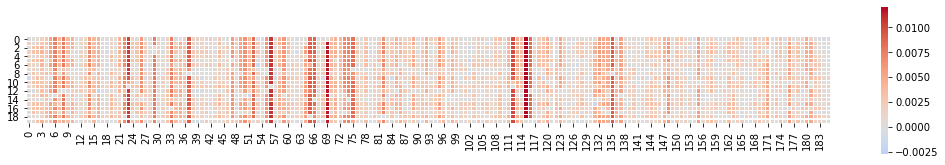

In [8]:
fig = plt.figure(figsize=(18, 3))
sns.heatmap(sm.transpose(), square=True, cbar=True,
            cmap="coolwarm", center=0, linewidths=0.05,
            cbar_kws={"shrink": .90})
pass

In [9]:
# double mutants as a numpy array
dm = np.zeros(shape=(config.L, config.AA_L, config.L, config.AA_L), dtype=float)

for key, val in double_mutant_energies_d.items():
    dm[key[0], key[1], val[0][:, 0], val[0][:, 1]] = val[1] - WT_energy

# Find the energy (relative to WT) for the mutant (0, 10), (1, 15)
# and check that it is correct.

x = double_mutant_energies_d[(0, 10)]
# find where (1, 15) is ## Ans 33
second_mut_loc = np.where((x[0][:, 0] == 1) & (x[0][:, 1] == 15))[0].item()

m = WT.copy()
m[0] = 10
m[1] = 15
assert(np.allclose(energy_calc(m) - WT_energy,  x[1][second_mut_loc] - WT_energy))
assert(np.allclose(energy_calc(m) - WT_energy,  dm[0,10,1, 15]))
dm[0, 10, 1, 15]

0.0038915657104030554

In [10]:
double_mutant_energies_list = []
for key, val in double_mutant_energies_d.items():
    i, a = key
    mut, energies = val
    df = pd.DataFrame({"j":mut[:, 0].astype(np.int16), 
                      "b":mut[:, 1].astype(np.int16),
                      "dbl_energy": energies
                      })
    df["i"] = np.int16(i)
    df["a"] = np.int16(a)
    df["i_energy"] = sm[i, a] + WT_energy
    df["j_energy"] = sm[df.j, df.b] + WT_energy
    double_mutant_energies_list.append(df)

double_df = pd.concat(double_mutant_energies_list)
double_df = double_df[double_df.i < double_df.j]

num_double_mutants = int((186 * 185 / 2) * (19 * 19))
assert(len(double_df) == num_double_mutants)

double_df.head()

,j,b,dbl_energy,i,a,i_energy,j_energy
19,1,1,0.790990,0,0,0.790377,0.791502
20,1,2,0.793484,0,0,0.790377,0.794007
21,1,3,0.793484,0,0,0.790377,0.794007
22,1,4,0.790186,0,0,0.790377,0.790710
23,1,5,0.793484,0,0,0.790377,0.794007


In [11]:
# check the energies of a small sample of the dataframe
test_df = double_df.sample(10).copy()

def check_energy(i=None,a=None,j=None,b=None):
    mut = WT.copy()
    if i is not None:
        mut[int(i)] = int(a)
    if j is not None:
        mut[int(j)] = int(b)
    return float(energy_calc(mut))

assert(np.allclose(check_energy(j=1,b=1, i=0, a=0),
                   double_df.dbl_energy.iloc[0]))

assert(np.allclose(test_df.dbl_energy.values,
            test_df.apply(lambda x: 
                check_energy(j=x.j, b=x.b, i=x["i"], a=x["a"]), 
                  axis=1).values))
assert(np.allclose(test_df.j_energy.values,
            test_df.apply(lambda x: check_energy(j=x.j, b=x.b), 
                  axis=1).values))
assert(np.allclose(test_df.i_energy.values,
            test_df.apply(lambda x: check_energy(i=x.i, a=x.a), 
                  axis=1).values))


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

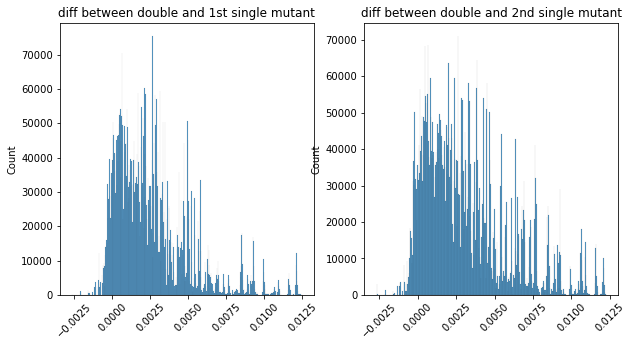

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(x=double_df.dbl_energy - double_df.i_energy, ax=axs[0])
sns.histplot(x=double_df.dbl_energy - double_df.j_energy, ax=axs[1])
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title("diff between double and 1st single mutant")
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title("diff between double and 2nd single mutant")

pass

In [14]:
double_df["wt_j"] = double_df.j.map(config.WT_AA.__getitem__)
double_df["wt_i"] = double_df.i.map(config.WT_AA.__getitem__)
double_df["uniprot_j"] = double_df.j + 2
double_df["uniprot_i"] = double_df.i + 2
double_df["b_aa"] = double_df.b.map(config.INV_AA_MAP)
double_df["a_aa"] = double_df.a.map(config.INV_AA_MAP)


In [15]:
sign_epi_mask = (
    ( np.sign(double_df.dbl_energy - double_df.j_energy) != np.sign(double_df.i_energy - WT_energy) ) | 
    ( np.sign(double_df.dbl_energy - double_df.i_energy) != np.sign(double_df.j_energy - WT_energy) ) )
double_df[sign_epi_mask]

,j,b,dbl_energy,i,a,i_energy,j_energy,wt_j,wt_i,uniprot_j,uniprot_i,b_aa,a_aa
533,28,1,0.790380,0,0,0.790377,0.790911,N,V,30,2,K,R
866,45,12,0.790392,0,0,0.790377,0.790913,K,V,47,2,A,R
1502,79,2,0.790379,0,0,0.790377,0.790911,K,V,81,2,D,R
1507,79,7,0.790381,0,0,0.790377,0.790912,K,V,81,2,S,R
1845,97,3,0.790390,0,0,0.790377,0.790911,R,V,99,2,E,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,183,19,0.792663,166,12,0.790901,0.792661,K,S,185,168,G,A
3493,183,17,0.790274,167,19,0.790276,0.790922,K,E,185,169,V,G
3449,181,11,0.791271,168,12,0.790890,0.791266,Y,V,183,170,W,A
3449,181,11,0.791271,168,18,0.790859,0.791266,Y,V,183,170,W,P


In [18]:
len(double_df[sign_epi_mask]) / len(double_df) * 100

0.3976007103520284

In [16]:
reci_sign_epi_mask = (
    ( np.sign(double_df.dbl_energy - double_df.j_energy) != np.sign(double_df.i_energy - WT_energy) ) & 
    ( np.sign(double_df.dbl_energy - double_df.i_energy) != np.sign(double_df.j_energy - WT_energy) ) )
double_df[reci_sign_epi_mask]

,j,b,dbl_energy,i,a,i_energy,j_energy,wt_j,wt_i,uniprot_j,uniprot_i,b_aa,a_aa
1845,97,3,0.790914,28,1,0.790911,0.790911,R,N,99,30,E,K
1502,79,2,0.790915,45,12,0.790913,0.790911,K,K,81,47,D,A
1507,79,7,0.790917,45,12,0.790913,0.790912,K,K,81,47,S,A
1845,97,3,0.790925,45,12,0.790913,0.790911,R,K,99,47,E,A
2630,138,8,0.790921,45,12,0.790913,0.790916,M,K,140,47,T,A
2933,154,8,0.790916,45,12,0.790913,0.790908,K,K,156,47,T,A
3068,161,9,0.790914,45,12,0.790913,0.790905,Y,K,163,47,C,A
3165,166,12,0.790916,45,12,0.790913,0.790901,S,K,168,47,A,A
1845,97,3,0.790912,79,7,0.790912,0.790911,R,K,99,81,E,S
2376,125,1,0.790918,97,3,0.790911,0.790916,N,R,127,99,K,E


In [17]:
len(double_df[reci_sign_epi_mask])

13